# Just operation policies of Guadalajara’s Aquapheric under drought conditions

## 2. Optimization Formulations

This notebook is designed to find the optimization formulations that can ensure that the optimal policies for the diversity of justice principle combinations can be found by filtering the pareto set. In other words, what a priori formulation can ensure an adecuate a posteriori implementation of the Distributive Justice 


In [1]:


from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant, Scenario, Constraint,optimize)

import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings


In [2]:
from AMG_function import AMG_model_function
from functions_data import full_dataframe
from AMG_drought_indicator import get_drought_state


outcomes = AMG_model_function(chapala_flow= 7.1, calderon_lared_flow= 0, pozos_flow= 2.2, toluquilla_flow= 0.4, 
                aqp1_PP2_to_PP3=0.205, aqp2_PP3_to_Pozos=-0.664, aqp3_Pozos_to_Toluquilla=-0.613, aqp4_Toluquilla_to_PP1=-0.639)
print(outcomes)


{'delivered_PP1': 5.751, 'delivered_PP2': 1.349, 'delivered_PP3': 0, 'delivered_Pozos': 2.2, 'delivered_Toluquilla': 0.4, 'demand_PP1': 2.932923333333333, 'demand_PP2': 0.7571686458333333, 'demand_PP3': 0.9435108680555555, 'demand_Toluquilla': 0.782294375, 'demand_Pozos': 1.2014250347222222, 'supplied_PP1': 2.64395196, 'supplied_PP2': 0.6822205, 'supplied_PP3': 0.8508500000000001, 'supplied_Toluquilla': 0.7044775400000001, 'supplied_Pozos': 1.0822500000000002, 'total_supplied': 5.96375, 'supplied_demand_PP1': 0.9014732604670881, 'supplied_demand_PP2': 0.901015254334989, 'supplied_demand_PP3': 0.9017914141821, 'supplied_demand_Toluquilla': 0.9005274261367405, 'supplied_demand_Pozos': 0.9008052676796633, 'supplied_demand_deficit_PP1': 0.09852673953291191, 'supplied_demand_deficit_PP2': 0.09898474566501103, 'supplied_demand_deficit_PP3': 0.09820858581790004, 'supplied_demand_deficit_Toluquilla': 0.09947257386325947, 'supplied_demand_deficit_Pozos': 0.09919473232033671, 'supply_percapita_P

c:\Users\ariel\anaconda3\envs\MBWSA\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


# 1. Ad-Hoc Convergence using HiperVolume

In [3]:
flows = ["chapala_flow", "calderon_lared_flow", "pozos_flow", "toluquilla_flow"]
representative_scenarios_df = pd.read_csv("results/representative_scenarios.csv",index_col=0)
representative_scenarios_df.head()

,chapala_flow,calderon_lared_flow,pozos_flow,toluquilla_flow,name
2021_drought,7.1,0,2.2,0.4,2021_drought
chapala_incident,1.8,1,2.2,0.4,chapala_incident
groundwater_scarcity,6.1,1,0.7,0.2,groundwater_scarcity


In [4]:
#Problem formulation
performance_outcomes = {"supplied_demand_deficit":True,
                          "supplied_demand":False,
                          "supply_percapita":False}

justice_outcomes = {"supplied_demand_GINI":True,
                      "supply_percapita_GINI":False,
                      "ZAs_below_142":False,
                      "ZAs_below_128":False,
                      "ZAs_below_100":False,
                      "ZAs_below_50":False}

other_outcomes = {"energy_costs":True}



#Model Parameters
n_nfe = 1000
epsilon = 0.04
seed = 1

#Scenario setting
flows = ["chapala_flow", "calderon_lared_flow", "pozos_flow", "toluquilla_flow"]
representative_scenarios_df = pd.read_csv("results/representative_scenarios.csv", index_col=0)
scenario_name = "2021_drought"
scenario = representative_scenarios_df.loc[scenario_name,flows+["name"]].to_dict()


all_outcomes = {**performance_outcomes, **justice_outcomes, **other_outcomes}
current_formulation = [outcome for outcome, active in all_outcomes.items() if active]

experiment_name = "-".join(current_formulation)+f" {scenario['name']}-{n_nfe}-{epsilon}-{seed}"
print(experiment_name)

supplied_demand_deficit-supplied_demand_GINI-energy_costs 2021_drought-1000-0.04-1


In [5]:
'''from AMG_optimization import run_optimization
from ema_workbench import HypervolumeMetric
from ema_workbench.em_framework.optimization import to_problem

results, run_time  = run_optimization(experiment_name=experiment_name,
                 model_function=AMG_model_function, 
                 outcomes= all_outcomes,
                 n_nfe = n_nfe, epsilon = epsilon, seed = seed,
                 scenario=scenario,
                 restriction = True)
print(all_outcomes)
results.head()'''

'from AMG_optimization import run_optimization\nfrom ema_workbench import HypervolumeMetric\nfrom ema_workbench.em_framework.optimization import to_problem\n\nresults, run_time  = run_optimization(experiment_name=experiment_name,\n                 model_function=AMG_model_function, \n                 outcomes= all_outcomes,\n                 n_nfe = n_nfe, epsilon = epsilon, seed = seed,\n                 scenario=scenario,\n                 restriction = True)\nprint(all_outcomes)\nresults.head()'

import numpy as np
import pandas as pd
from platypus import EpsNSGAII, ProcessPoolEvaluator
from functions_data import full_dataframe, find_compromise
from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Scenario, Constraint, optimize, IntegerParameter)

from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress)

from AMG_function import AMG_model_function
import random
import time
import logging

#Problem formulation
performance_outcomes = {"supplied_demand_deficit":True,
                          "supplied_demand":False,
                          "supply_percapita":False}

justice_outcomes = {"supplied_demand_GINI":True,
                      "supply_percapita_GINI":False,
                      "ZAs_below_142":False,
                      "ZAs_below_128":False,
                      "ZAs_below_100":False,
                      "ZAs_below_50":False}

other_outcomes = {"energy_costs":True}



#Model Parameters
n_nfe = 100000
epsilon = 0.4
seed = 1

#Scenario setting
flows = ["chapala_flow", "calderon_lared_flow", "pozos_flow", "toluquilla_flow"]
representative_scenarios_df = pd.read_csv("results/representative_scenarios.csv", index_col=0)
scenario = representative_scenarios_df.loc["HIGH",flows+["name"]].to_dict()


all_outcomes = {**performance_outcomes, **justice_outcomes, **other_outcomes}
current_formulation = [outcome for outcome, active in all_outcomes.items() if active]

experiment_name = "-".join(current_formulation)+f" {scenario['name']}-{n_nfe}-{epsilon}-{seed}"
print(experiment_name)

experiment_name=experiment_name
model_function=AMG_model_function

n_nfe = n_nfe
epsilon = epsilon
seed = seed
scenario=scenario
scenario_name = scenario["name"]
restriction = True
rounding_levers = 2
experiment_name = "-".join(current_formulation)+f" {scenario['name']}-{n_nfe}-{epsilon}-{seed}"

scenario = Scenario(**scenario)



#Setting the stage
ema_logging.log_to_stderr(ema_logging.INFO)

ZA_names = ["PP1", "PP2", "PP3", "Toluquilla", "Pozos"]

#instantiate the model
AMG_model = Model("AMGmodel", function = model_function)


#LEVERS
#Define a resolution to round levers and avoid finding solutions with unecesary precision considering uncertainties
scale = 10**rounding_levers

#Currently water can't flow between pozos and Toluquilla due to heigh difference. We call this the restriction.
if restriction == True: 
    pozos_to_toluquilla = 0 
    #resolution_pozos_to_toluquilla = np.round(np.linspace(-1, 0, 10**rounding_levers, rounding_levers)).tolist()
else: 
    pozos_to_toluquilla = 1
    #resolution_pozos_to_toluquilla = resolution


AMG_model.levers = [IntegerParameter('aqp1_PP2_to_PP3', -1*scale, 1*scale),
                    IntegerParameter('aqp2_PP3_to_Pozos', -1*scale, 1*scale),
                    IntegerParameter('aqp3_Pozos_to_Toluquilla', -1*scale, pozos_to_toluquilla*scale),
                    IntegerParameter('aqp4_Toluquilla_to_PP1', -1*scale, 1*scale)]

#OUTCOMES
maximizing_outcomes = [*[f'supplied_demand_{ZA}' for ZA in ZA_names if "supplied_demand" in current_formulation],
                    *[f'supply_percapita_{ZA}' for ZA in ZA_names if "supply_percapita" in current_formulation]]

minimizing_outcomes = [*[f'supplied_demand_deficit_{ZA}' for ZA in ZA_names if "supplied_demand_deficit" in current_formulation],
                    *[ outcome for outcome in ['supplied_demand_GINI', 'supply_percapita_GINI', 'energy_costs', "ZAs_below_142", "ZAs_below_128","ZAs_below_100","ZAs_below_50"] if outcome in current_formulation]]

info_outcomes = [*[f"supplied_{ZA}" for ZA in ZA_names]]

AMG_model.outcomes = [ScalarOutcome(scalar_outcome, kind=ScalarOutcome.MAXIMIZE) for scalar_outcome in maximizing_outcomes] + [
    ScalarOutcome(minimizing_outcome, kind=ScalarOutcome.MINIMIZE) for minimizing_outcome in minimizing_outcomes] + [
    ScalarOutcome(info_outcome, kind=ScalarOutcome.INFO) for info_outcome in info_outcomes]


#Optimization
logging.info(f"Starting optimization for {experiment_name} with n_nfe={n_nfe}")
ema_logging.log_to_stderr(ema_logging.INFO)

#calculate outcomes but substracting the info outcomes for the epsilons in the optimizaiton
n_outcomes = len(AMG_model.outcomes)-len(info_outcomes)

#Constrain
non_negative_outcomes = [f"supplied_{ZA}" for ZA in ZA_names]
constraints = [Constraint("non_negative_constrain", outcome_names= outcome, 
                        function=lambda x: max(0, -x)) for outcome in non_negative_outcomes]

random.seed(seed)
np.random.seed(seed)

#start a timer
start_time = time.time()

# Define decision variable and outcome names
decision_varnames = [lever.name for lever in AMG_model.levers]
outcome_varnames = [outcome.name for outcome in AMG_model.outcomes]

convergence_metrics = [
    ArchiveLogger(
        f"./archives/seed{seed}",
        [l.name for l in AMG_model.levers],
        [o.name for o in AMG_model.outcomes],
        base_filename="logger.tar.gz",
    ),
    EpsilonProgress(),
]


with MultiprocessingEvaluator(AMG_model) as evaluator:
    results, convergence = evaluator.optimize(
        nfe=n_nfe, searchover="levers", epsilons=[epsilon] * n_outcomes, constraints=constraints, reference=scenario,
        convergence= convergence_metrics
    )

# End timing
end_time = time.time()

# Compute the duration
duration = round(end_time - start_time,0)
results["experiment_name"] = experiment_name
results["seed"] = seed
results["scenario"] = scenario_name

logging.info(f"Completed optimization for {experiment_name} in {duration} seconds")

archives = ArchiveLogger.load_archives(f"archives/seed{seed}/logger.tar.gz")
reference_set = results.drop(columns=["experiment_name", "seed", "scenario"])
cols = reference_set.columns
for key in archives.keys():
    archives[key] = archives[key][cols]


from ema_workbench import HypervolumeMetric
from ema_workbench.em_framework.optimization import to_problem

problem = to_problem(AMG_model, searchover="levers")

hv = HypervolumeMetric(reference_set, problem)

hypervolume = [(nfe, hv.calculate(archive)) for nfe, archive in archives.items()]
hypervolume.sort(key=lambda x:x[0])
hypervolume = np.asarray(hypervolume)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.savefig(f"3_convergence/{experiment_name}.jpg")
plt.show()

In [7]:
import numpy as np
import pandas as pd
from platypus import EpsNSGAII, ProcessPoolEvaluator
from functions_data import full_dataframe, find_compromise
from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Scenario, Constraint, optimize, IntegerParameter)

from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress)

from AMG_function import AMG_model_function
import random
import time
import logging


#Problem formulation
performance_outcomes = {"supplied_demand_deficit":True,
                          "supplied_demand":False,
                          "supply_percapita":False}

justice_outcomes = {"supplied_demand_GINI":False,
                      "supply_percapita_GINI":True,
                      "supply_percapita_average": False,
                      "ZAs_below_142":False,
                      "ZAs_below_128":False,
                      "ZAs_below_100":False,
                      "ZAs_below_50":False}

other_outcomes = {"energy_costs":True}

hypervolume_df = pd.DataFrame()

for seed in [1]:

    #Model Parameters
    n_nfe = 50000
    epsilon = 0.1

    #Scenario setting
    flows = ["chapala_flow", "calderon_lared_flow", "pozos_flow", "toluquilla_flow"]
    representative_scenarios_df = pd.read_csv("results/representative_scenarios.csv", index_col=0)
    scenario = representative_scenarios_df.loc[scenario_name,flows+["name"]].to_dict()


    all_outcomes = {**performance_outcomes, **justice_outcomes, **other_outcomes}
    current_formulation = [outcome for outcome, active in all_outcomes.items() if active]

    experiment_name = "-".join(current_formulation)+f" {scenario['name']}-{n_nfe}-{epsilon}-{seed}"
    print(experiment_name)

    experiment_name=experiment_name
    model_function=AMG_model_function

    n_nfe = n_nfe
    epsilon = epsilon
    seed = seed
    scenario=scenario
    scenario_name = scenario["name"]
    restriction = True
    rounding_levers = 3
    experiment_name = "-".join(current_formulation)+f" {scenario['name']}-{n_nfe}-{epsilon}-{seed}"

    scenario = Scenario(**scenario)



    #Setting the stage
    ema_logging.log_to_stderr(ema_logging.INFO)

    ZA_names = ["PP1", "PP2", "PP3", "Toluquilla", "Pozos"]

    #instantiate the model
    AMG_model = Model("AMGmodel", function = model_function)


    #LEVERS
    AMG_model.levers = [RealParameter('aqp1_PP2_to_PP3', -1, 1),
                    RealParameter('aqp2_PP3_to_Pozos', -1, 1),
                    RealParameter('aqp3_Pozos_to_Toluquilla', -1, 0),
                    RealParameter('aqp4_Toluquilla_to_PP1', -1, 1)]

    #OUTCOMES
    maximizing_outcomes = [*[f'supplied_demand_{ZA}' for ZA in ZA_names if "supplied_demand" in current_formulation],
                        *[f'supply_percapita_{ZA}' for ZA in ZA_names if "supply_percapita" in current_formulation]]

    minimizing_outcomes = [*[f'supplied_demand_deficit_{ZA}' for ZA in ZA_names if "supplied_demand_deficit" in current_formulation],
                        *[ outcome for outcome in ['supplied_demand_GINI', 'supply_percapita_GINI', 'energy_costs', "ZAs_below_142", "ZAs_below_128","ZAs_below_100","ZAs_below_50"] if outcome in current_formulation]]

    info_outcomes = [*[f"supplied_{ZA}" for ZA in ZA_names]]

    AMG_model.outcomes = [ScalarOutcome(scalar_outcome, kind=ScalarOutcome.MAXIMIZE) for scalar_outcome in maximizing_outcomes] + [
        ScalarOutcome(minimizing_outcome, kind=ScalarOutcome.MINIMIZE) for minimizing_outcome in minimizing_outcomes] + [
        ScalarOutcome(info_outcome, kind=ScalarOutcome.INFO) for info_outcome in info_outcomes]


    #Optimization
    logging.info(f"Starting optimization for {experiment_name} with n_nfe={n_nfe}")
    ema_logging.log_to_stderr(ema_logging.INFO)

    #calculate outcomes but substracting the info outcomes for the epsilons in the optimizaiton
    n_outcomes = len(AMG_model.outcomes)-len(info_outcomes)

    #Constrain
    non_negative_outcomes = [f"supplied_{ZA}" for ZA in ZA_names]
    constraints = [Constraint("non_negative_constrain", outcome_names= outcome, 
                            function=lambda x: max(0, -x)) for outcome in non_negative_outcomes]

    random.seed(seed)
    np.random.seed(seed)

    #start a timer
    start_time = time.time()

    # Define decision variable and outcome names
    decision_varnames = [lever.name for lever in AMG_model.levers]
    outcome_varnames = [outcome.name for outcome in AMG_model.outcomes]

    convergence_metrics = [
        ArchiveLogger(
            f"./archives",
            [l.name for l in AMG_model.levers],
            [o.name for o in AMG_model.outcomes],
            base_filename="logger.tar.gz",
        ),
        EpsilonProgress(),
    ]


    with MultiprocessingEvaluator(AMG_model) as evaluator:
        results, convergence = evaluator.optimize(
            nfe = n_nfe, 
            searchover="levers", 
            epsilons = [epsilon] * n_outcomes, 
            constraints = constraints, 
            reference = scenario,
            convergence = convergence_metrics
        )

    # End timing
    end_time = time.time()

    # Compute the duration
    duration = round(end_time - start_time,0)
    results["experiment_name"] = experiment_name
    results["seed"] = seed
    results["scenario"] = scenario_name

    logging.info(f"Completed optimization for {experiment_name} in {duration} seconds")

    archives = ArchiveLogger.load_archives(f"archives/logger.tar.gz")
    reference_set = results.drop(columns=["experiment_name", "seed", "scenario"])
    cols = reference_set.columns
    for key in archives.keys():
        archives[key] = archives[key][cols]


    from ema_workbench import HypervolumeMetric
    from ema_workbench.em_framework.optimization import to_problem

    problem = to_problem(AMG_model, searchover="levers")

    hv = HypervolumeMetric(reference_set, problem)

    hypervolume = [(nfe, hv.calculate(archive)) for nfe, archive in archives.items()]
    hypervolume.sort(key=lambda x:x[0])
    hypervolume = pd.DataFrame(hypervolume)
    hypervolume["seed"] = seed

    hypervolume_df = pd.concat([hypervolume, hypervolume_df], axis = 0)



supplied_demand_deficit-supply_percapita_GINI-energy_costs 2021_drought-50000-0.1-1


[MainProcess/INFO] pool started with 8 workers
50263it [06:11, 135.46it/s]                                                    
[MainProcess/INFO] optimization completed, found 76 solutions
[MainProcess/INFO] terminating pool


In [ ]:
hypervolume_df.to_csv("results/convergence_HIGH_rd3_allJoForm.csv", index = False)
hypervolume_df.to_clipboard()

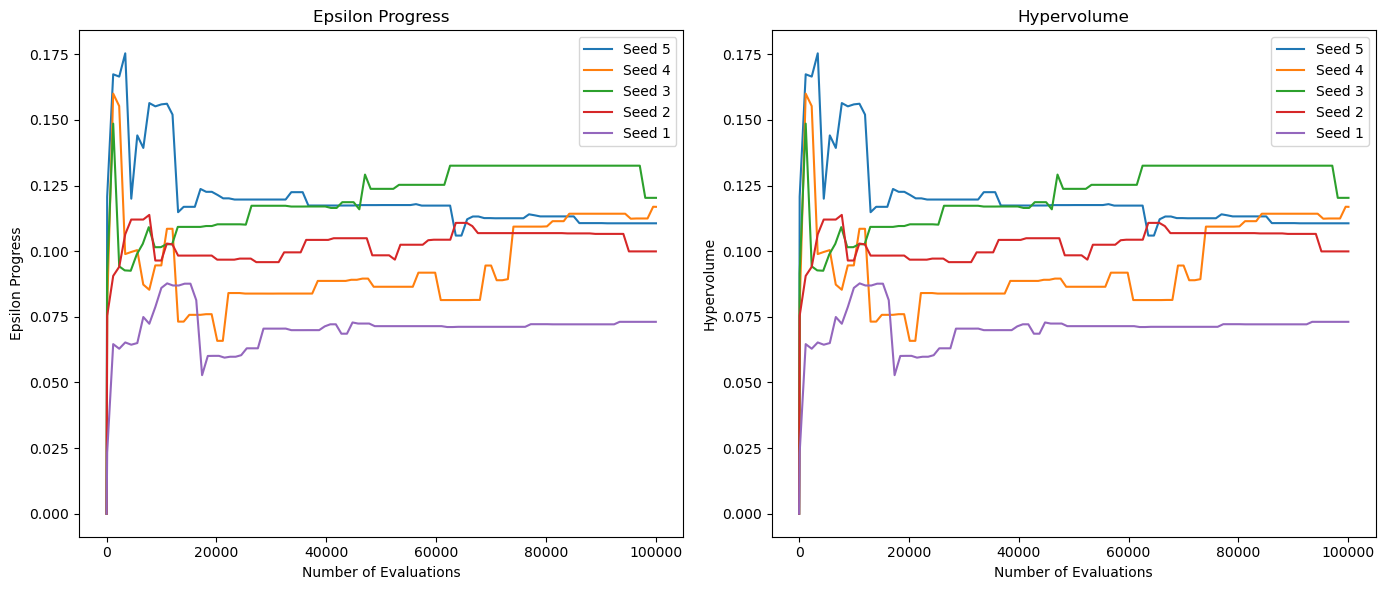

In [ ]:
# Plotting
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

# Plot epsilon progress
for seed in hypervolume_df['seed'].unique():
    data_seed = hypervolume_df[hypervolume_df['seed'] == seed]
    ax1.plot(data_seed[0], data_seed[1], label=f'Seed {seed}')

ax1.set_title('Epsilon Progress')
ax1.set_xlabel('Number of Evaluations')
ax1.set_ylabel('Epsilon Progress')
ax1.legend()

# Plot hypervolume
for seed in hypervolume_df['seed'].unique():
    data_seed = hypervolume_df[hypervolume_df['seed'] == seed]
    ax2.plot(data_seed[0], data_seed[1], label=f'Seed {seed}')

ax2.set_title('Hypervolume')
ax2.set_xlabel('Number of Evaluations')
ax2.set_ylabel('Hypervolume')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
results.head()

,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,supplied_demand_deficit_PP1,supplied_demand_deficit_PP2,supplied_demand_deficit_PP3,supplied_demand_deficit_Toluquilla,supplied_demand_deficit_Pozos,supplied_demand_GINI,energy_costs,experiment_name,seed,scenario
0,-349,-190,-740,-596,0.794,0.352,0.791,0.805,0.379,0.281,0.469,supplied_demand_deficit-supplied_demand_GINI-e...,5,rep_scen_HIGH
1,-5,437,-102,-512,0.776,0.647,0.985,0.345,0.385,0.359,0.264,supplied_demand_deficit-supplied_demand_GINI-e...,5,rep_scen_HIGH
2,-298,-720,-195,-312,0.731,0.395,0.390,0.588,0.960,0.305,0.381,supplied_demand_deficit-supplied_demand_GINI-e...,5,rep_scen_HIGH
3,-311,-728,-514,-966,0.876,0.384,0.394,0.310,0.792,0.275,0.630,supplied_demand_deficit-supplied_demand_GINI-e...,5,rep_scen_HIGH
4,-321,-750,-240,-611,0.798,0.376,0.385,0.377,0.952,0.298,0.480,supplied_demand_deficit-supplied_demand_GINI-e...,5,rep_scen_HIGH


In [ ]:
aas
archives = ArchiveLogger.load_archives("archives\logger.tar.gz")
reference_set = results.drop(columns=["experiment_name", "seed", "scenario"])
cols = reference_set.columns
for key in archives.keys():
    archives[key] = archives[key][cols]



NameError: name 'aas' is not defined

In [ ]:
reference_set

,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,supplied_demand_deficit_PP1,supplied_demand_deficit_PP2,supplied_demand_deficit_PP3,supplied_demand_deficit_Toluquilla,supplied_demand_deficit_Pozos,supplied_demand_GINI,energy_costs
0,9,-33,-16,-58,0.791,0.728,0.392,0.336,0.768,0.259,0.290
1,-31,-19,-71,-35,0.740,0.385,0.764,0.985,0.395,0.362,0.390
2,31,-11,-67,-60,0.795,0.917,0.392,0.744,0.373,0.335,0.422
3,-35,-79,-61,-96,0.875,0.351,0.378,0.395,0.774,0.259,0.678
4,7,-34,-90,-100,0.884,0.711,0.399,0.602,0.373,0.263,0.578
5,8,46,-8,-51,0.775,0.720,0.943,0.328,0.384,0.350,0.282
6,-33,10,-52,-100,0.884,0.368,0.977,0.287,0.341,0.359,0.488
7,16,-25,-77,-55,0.784,0.788,0.399,0.868,0.395,0.303,0.433
8,3,0,-56,-60,0.795,0.677,0.660,0.652,0.373,0.188,0.298
9,-30,-18,0,-53,0.780,0.394,0.764,0.245,0.774,0.284,0.252


In [ ]:
from ema_workbench import HypervolumeMetric
from ema_workbench.em_framework.optimization import to_problem

problem = to_problem(AMG_model, searchover="levers")

hv = HypervolumeMetric(reference_set, problem)

hypervolume = [(nfe, hv.calculate(archive)) for nfe, archive in archives.items()]
hypervolume.sort(key=lambda x:x[0])
hypervolume.head()
hypervolume = np.asarray(hypervolume)

AttributeError: 'list' object has no attribute 'head'

In [ ]:
# Create an empty DataFrame to store hypervolume values
hypervolume_df = pd.DataFrame(columns=['Seed', 'NFE', 'Hypervolume'])

problem = to_problem(AMG_model, searchover="levers")
hv = HypervolumeMetric(reference_set, problem)

# Iterate over each seed and calculate hypervolume
for seed, archive in archives.items():
    if archive.empty:
        logging.warning(f"No archive found for seed {seed}. Skipping.")
        continue
    
    # Calculate hypervolume for this seed's archive
    hv_value = hv.calculate(archive)
    
    # Append to hypervolume DataFrame
    hypervolume_df = hypervolume_df.append({'Seed': seed, 'NFE': seed, 'Hypervolume': hv_value}, ignore_index=True)

# Convert NFE column to int
hypervolume_df['NFE'] = hypervolume_df['NFE'].astype(int)

# Display or save hypervolume_df for verification
print(hypervolume_df.head())

       Seed     NFE  Hypervolume
0     100.0     100     0.033475
1  100008.0  100008     0.089569
2   11040.0   11040     0.122677
3    1198.0    1198     0.100504
4   12046.0   12046     0.122677


C:\Users\ariel\AppData\Local\Temp\ipykernel_3692\2111760419.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


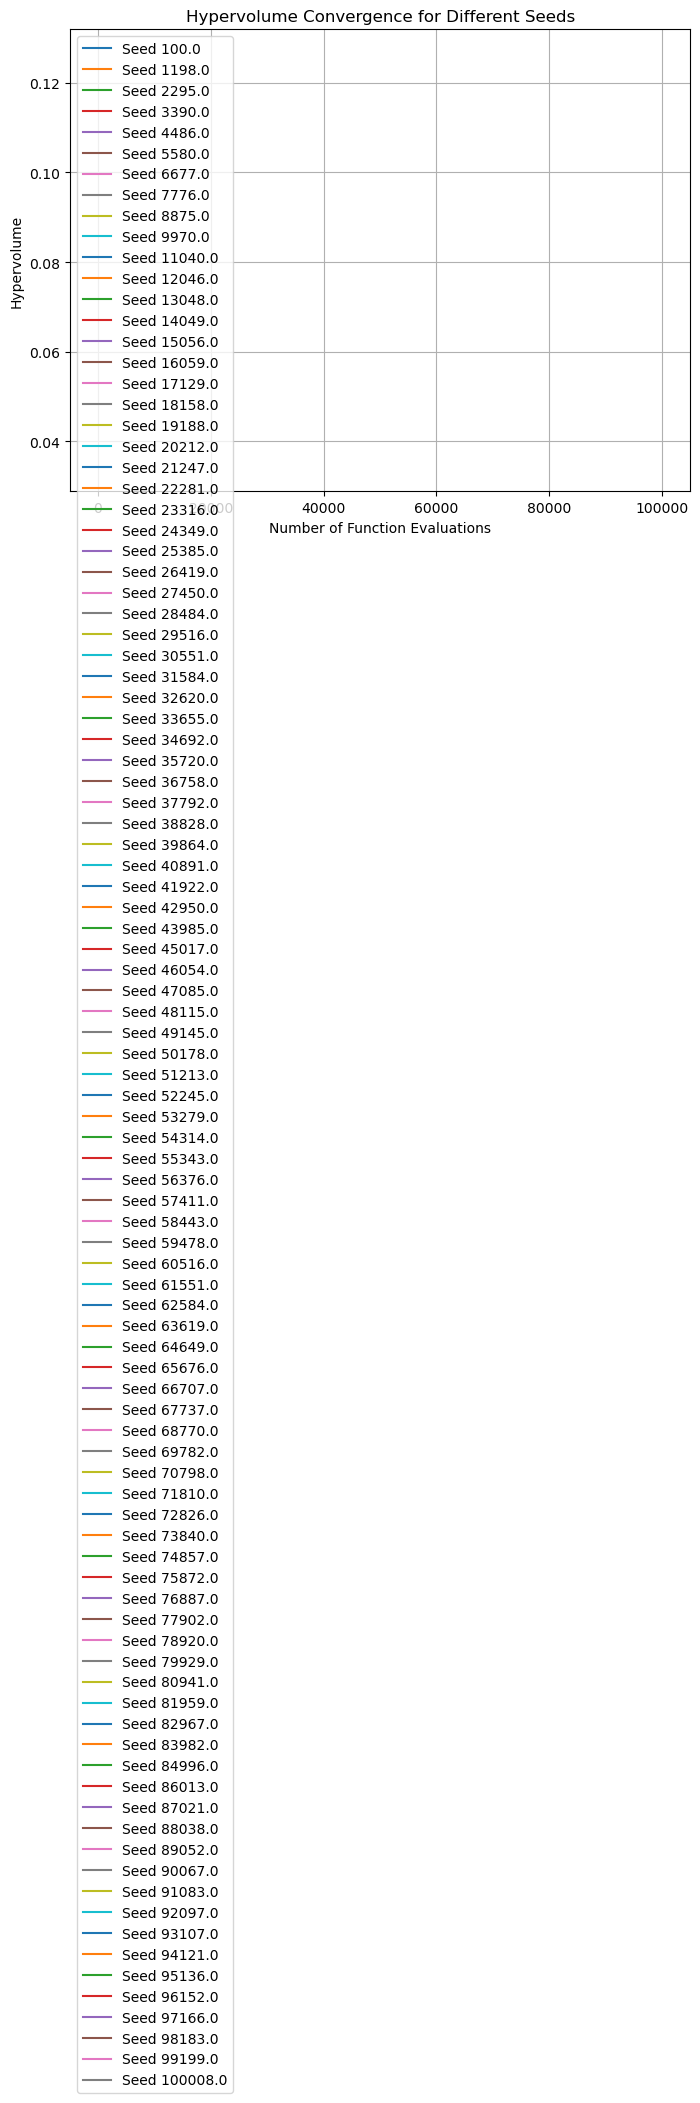

In [ ]:
import matplotlib.pyplot as plt

# Plotting multiple lines based on the Seed column
fig, ax = plt.subplots(figsize=(8, 6))

# Iterate over each seed and plot hypervolume convergence
for seed, group in hypervolume_df.groupby('Seed'):
    ax.plot(group['NFE'], group['Hypervolume'], label=f'Seed {seed}')

ax.set_xlabel('Number of Function Evaluations')
ax.set_ylabel('Hypervolume')
ax.set_title('Hypervolume Convergence for Different Seeds')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
asd

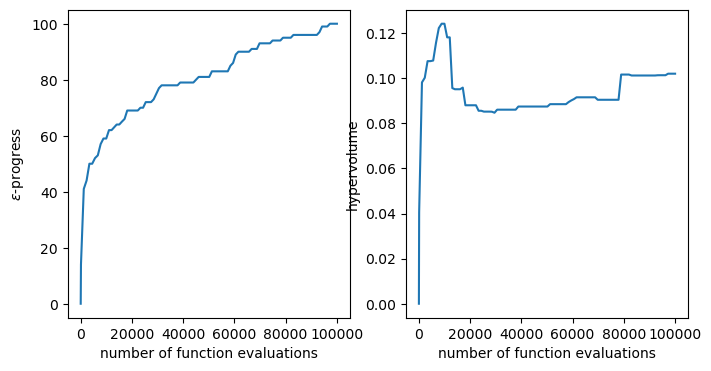

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.savefig(f"3_convergence/{experiment_name}.jpg")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ema_workbench import (Model, ScalarOutcome, ema_logging, Scenario, Constraint, MultiprocessingEvaluator, optimize, IntegerParameter)
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress
from ema_workbench.em_framework.optimization import to_problem
from ema_workbench import HypervolumeMetric
from ema_workbench.analysis import plotting
import time
import logging
import random
from AMG_function import AMG_model_function

def run_optimization(experiment_name,
                     model_function=AMG_model_function, 
                     outcomes={"supplied_demand_deficit": True, "supplied_demand": False, "supply_percapita": False,
                               "supplied_demand_GINI": False, "supply_percapita_GINI": True, 
                               "ZAs_below_142": False, "ZAs_below_128": False, "ZAs_below_100": False, "ZAs_below_50": False,
                               "energy_costs": True},
                     n_nfe=100000, epsilon=0.4, seeds=[1, 2, 3, 4, 5],
                     scenario={"name": "2020_baseline", 'chapala_flow': 6.9, 'calderon_lared_flow': 1, 'pozos_flow': 2.3, 'toluquilla_flow': 0.5},
                     restriction=True,
                     rounding_levers=2):
    
    scenario = Scenario(**scenario)
    all_outcomes = outcomes
    current_formulation = [outcome for outcome, active in all_outcomes.items() if active]

    ema_logging.log_to_stderr(ema_logging.INFO)

    ZA_names = ["PP1", "PP2", "PP3", "Toluquilla", "Pozos"]

    results_all_seeds = []

    for seed in seeds:
        experiment_name_seed = f"{experiment_name}_seed_{seed}"

        # Instantiate the model
        AMG_model = Model("AMGmodel", function=model_function)

        # Levers
        scale = 10**rounding_levers
        
        if restriction:
            pozos_to_toluquilla = 0
        else:
            pozos_to_toluquilla = 1

        AMG_model.levers = [
            IntegerParameter('aqp1_PP2_to_PP3', -1*scale, 1*scale),
            IntegerParameter('aqp2_PP3_to_Pozos', -1*scale, 1*scale),
            IntegerParameter('aqp3_Pozos_to_Toluquilla', -1*scale, pozos_to_toluquilla*scale),
            IntegerParameter('aqp4_Toluquilla_to_PP1', -1*scale, 1*scale)
        ]

        # Outcomes
        maximizing_outcomes = [f'supplied_demand_{ZA}' for ZA in ZA_names if "supplied_demand" in current_formulation] + \
                              [f'supply_percapita_{ZA}' for ZA in ZA_names if "supply_percapita" in current_formulation]

        minimizing_outcomes = [f'supplied_demand_deficit_{ZA}' for ZA in ZA_names if "supplied_demand_deficit" in current_formulation] + \
                              ['supplied_demand_GINI', 'supply_percapita_GINI', 'energy_costs', "ZAs_below_142", "ZAs_below_128",
                               "ZAs_below_100", "ZAs_below_50"]

        info_outcomes = [f"supplied_{ZA}" for ZA in ZA_names]

        AMG_model.outcomes = [ScalarOutcome(scalar_outcome, kind=ScalarOutcome.MAXIMIZE) for scalar_outcome in maximizing_outcomes] + \
                             [ScalarOutcome(minimizing_outcome, kind=ScalarOutcome.MINIMIZE) for minimizing_outcome in minimizing_outcomes] + \
                             [ScalarOutcome(info_outcome, kind=ScalarOutcome.INFO) for info_outcome in info_outcomes]

        # Optimization
        logging.info(f"Starting optimization for {experiment_name_seed} with n_nfe={n_nfe}")
        ema_logging.log_to_stderr(ema_logging.INFO)

        n_outcomes = len(AMG_model.outcomes) - len(info_outcomes)

        non_negative_outcomes = [f"supplied_{ZA}" for ZA in ZA_names]
        constraints = [Constraint("non_negative_constrain", outcome_names=outcome, function=lambda x: max(0, -x)) for outcome in non_negative_outcomes]

        random.seed(seed)
        np.random.seed(seed)

        start_time = time.time()

        convergence_metrics = [
            ArchiveLogger(
                "./archives",
                [l.name for l in AMG_model.levers],
                [o.name for o in AMG_model.outcomes],
                base_filename=f"logger_seed_{seed}.tar.gz",
            ),
            EpsilonProgress(),
        ]

        with MultiprocessingEvaluator(AMG_model) as evaluator:
            results, convergence = evaluator.optimize(
                nfe=n_nfe, searchover="levers", epsilons=[epsilon] * n_outcomes, constraints=constraints, reference=scenario,
                convergence=convergence_metrics
            )

        end_time = time.time()
        duration = round(end_time - start_time, 0)
        results["experiment_name"] = experiment_name_seed
        results["seed"] = seed
        results_all_seeds.append(results)

        logging.info(f"Completed optimization for {experiment_name_seed} in {duration} seconds")

    # Aggregate hypervolume across seeds
    reference_sets = {}
    for seed in seeds:
        archives = ArchiveLogger.load_archives(f"archives/logger_seed_{seed}.tar.gz")
        reference_sets[seed] = pd.DataFrame(results_all_seeds[seed - 1].drop(columns=["experiment_name", "seed"]))
        cols = reference_sets[seed].columns
        for key in archives.keys():
            archives[key] = archives[key][cols]
        

    ''' reference_set = results.drop(columns=["experiment_name", "seed"])
       cols = reference_set.columns
    for key in archives.keys():
        archives[key] = archives[key][cols]'''

    problem = to_problem(AMG_model, searchover="levers")
    hv_metrics = HypervolumeMetric(reference_sets[seeds[0]], problem)

    hypervolumes = {}
    for seed in seeds:
        hypervolumes[seed] = [(nfe, hv_metrics.calculate(archive)) for nfe, archive in archives.items()]
        hypervolumes[seed].sort(key=lambda x: x[0])

    # Plot convergence and hypervolume for all seeds
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

    for seed in seeds:
        plotting.plot_convergence(convergence_metrics[seed - 1], ax=ax1, label=f"Seed {seed}")
        ax2.plot(hypervolumes[seed][:, 0], hypervolumes[seed][:, 1], label=f"Seed {seed}")

    ax1.set_title('Convergence Plot')
    ax1.set_xlabel('Number of Evaluations')
    ax1.set_ylabel('Hypervolume')

    ax2.set_title('Hypervolume Plot')
    ax2.set_xlabel('Number of Evaluations')
    ax2.set_ylabel('Hypervolume')

    ax1.legend()
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return results_all_seeds, duration

#Scenario setting
flows = ["chapala_flow", "calderon_lared_flow", "pozos_flow", "toluquilla_flow"]
representative_scenarios_df = pd.read_csv("results/representative_scenarios.csv", index_col=0)
scenario = representative_scenarios_df.loc["HIGH",flows+["name"]].to_dict()

# Example usage
results_all_seeds, duration = run_optimization(
    experiment_name="AMG_optimization",
    n_nfe=10000,
    epsilon=0.4,
    seeds=[1, 2],
    scenario=scenario,
    restriction=True,
    rounding_levers=2
)


c:\Users\ariel\anaconda3\envs\MBWSA\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)
[MainProcess/INFO] pool started with 8 workers
10465it [00:47, 219.50it/s]                                                    
[MainProcess/INFO] optimization completed, found 129 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
10463it [00:46, 224.10it/s]                                                    
[MainProcess/INFO] optimization completed, found 123 solutions
[MainProcess/INFO] terminating pool


KeyboardInterrupt: 

In [ ]:
results.head()

,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,supplied_demand_deficit_PP1,supplied_demand_deficit_PP2,supplied_demand_deficit_PP3,supplied_demand_deficit_Toluquilla,supplied_demand_deficit_Pozos,supplied_demand_GINI,energy_costs,experiment_name,seed,scenario
0,9,-33,-16,-58,0.791,0.728,0.392,0.336,0.768,0.259,0.290,supplied_demand_deficit-supplied_demand_GINI-e...,1,rep_scen_HIGH
1,-30,-78,-65,-60,0.795,0.394,0.350,0.727,0.747,0.250,0.582,supplied_demand_deficit-supplied_demand_GINI-e...,1,rep_scen_HIGH
2,-31,-19,-71,-35,0.740,0.385,0.764,0.985,0.395,0.362,0.390,supplied_demand_deficit-supplied_demand_GINI-e...,1,rep_scen_HIGH
3,-35,-79,-61,-96,0.875,0.351,0.378,0.395,0.774,0.259,0.678,supplied_demand_deficit-supplied_demand_GINI-e...,1,rep_scen_HIGH
4,7,-34,-90,-100,0.884,0.711,0.399,0.602,0.373,0.263,0.578,supplied_demand_deficit-supplied_demand_GINI-e...,1,rep_scen_HIGH
